This notebook builds a framework for finetuning a pretrained a model or using it as a fixed feature extractor.<br>

Please note that this notebook was originally ran on kaggle and downloaded afterward, so the current paths are not correct for re-running.<br>
To run it, please change the paths to the correct ones.<br>
<br>
The dataset used in this notebook is available at https://www.kaggle.com/huangruichu/caltech101 and the pretrained pytorch models are available at https://www.kaggle.com/mhiro2/pytorch-pretrained-models.<br><br>
**credit**: boilerplate finetuning code in this notebook is adapted from the official pytorch tutorial which can be found at https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html.

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import copy

plt.ion()   # interactive mode

In [3]:
model_dir = "/kaggle/input/pytorch-pretrained-models/"
model_name = 'vgg11_bn'
num_classes = 101
batch_size = 8
num_epochs = 25
# feature_extract: Flag for feature extracting. False: finetune the whole model; True: only update the reshaped layer params
feature_extract = False

In [4]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [5]:
def initialize_model(model_name, num_classes, feature_extract):

    if model_name == "resnet18":
        model_ft = models.resnet18()
        model_ft.load_state_dict(torch.load(model_dir + 'resnet18-5c106cde.pth'))
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":

        model_ft = models.alexnet()
        model_ft.load_state_dict(torch.load(model_dir + 'alexnet-owt-4df8aa71.pth'))
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg11_bn":
        
        model_ft = models.vgg11_bn()
        model_ft.load_state_dict(torch.load(model_dir + 'vgg11_bn-6002323d.pth'))
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet1_0":

        model_ft = models.squeezenet1_0()
        model_ft.load_state_dict(torch.load(model_dir + 'squeezenet1_0-a815701f.pth'))
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet121":

        model_ft = models.densenet121()
        model_ft.load_state_dict(torch.load(model_dir + 'densenet121-fbdb23505.pth'))
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes) 
        input_size = 224

    elif model_name == "inception":
        # Inception v3 expects (299,299) sized images and has auxiliary output
       
        model_ft = models.inception_v3()
        model_ft.load_state_dict(torch.load(model_dir + 'inception_v3_google-1a9a5a14.pth'))
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()
    
    return model_ft, input_size

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    statistics = {'train':([],[]), 'eval':([],[])} # train:(loss,acc), test:(loss,acc)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'eval']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
#             step_loss = []
#             step_acc = []
                      
            for step,(inputs, labels) in enumerate(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward，track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
#                 step_loss.append(loss.item() * inputs.size(0))
#                 step_acc.append(float(torch.sum(preds == labels.data)/preds.size(0)))
                
                # statistics                
#                 if step%99==1:
#                     statistics[phase][0].append(np.mean(step_loss))
#                     statistics[phase][1].append(np.mean(step_acc))
#                     step_loss = []
#                     step_acc = []
                    
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            statistics[phase][0].append(epoch_loss)
            statistics[phase][1].append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'eval' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best eval Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model, statistics

In [7]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'eval': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/kaggle/input/caltech101/Caltech101'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'eval', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8, shuffle=True, num_workers=4) for x in ['train', 'eval', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'eval', 'test']}
class_names = image_datasets['train'].classes
# num_classes = len(class_names)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(class_names)

cuda:0
['Faces', 'Faces_easy', 'Leopards', 'Motorbikes', 'accordion', 'airplanes', 'anchor', 'ant', 'barrel', 'bass', 'beaver', 'binocular', 'bonsai', 'brain', 'brontosaurus', 'buddha', 'butterfly', 'camera', 'cannon', 'car_side', 'ceiling_fan', 'cellphone', 'chair', 'chandelier', 'cougar_body', 'cougar_face', 'crab', 'crayfish', 'crocodile', 'crocodile_head', 'cup', 'dalmatian', 'dollar_bill', 'dolphin', 'dragonfly', 'electric_guitar', 'elephant', 'emu', 'euphonium', 'ewer', 'ferry', 'flamingo', 'flamingo_head', 'garfield', 'gerenuk', 'gramophone', 'grand_piano', 'hawksbill', 'headphone', 'hedgehog', 'helicopter', 'ibis', 'inline_skate', 'joshua_tree', 'kangaroo', 'ketch', 'lamp', 'laptop', 'llama', 'lobster', 'lotus', 'mandolin', 'mayfly', 'menorah', 'metronome', 'minaret', 'nautilus', 'octopus', 'okapi', 'pagoda', 'panda', 'pigeon', 'pizza', 'platypus', 'pyramid', 'revolver', 'rhino', 'rooster', 'saxophone', 'schooner', 'scissors', 'scorpion', 'sea_horse', 'snoopy', 'soccer_ball', '

## fine tuning (or feature extract)

In [8]:
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract)
model_ft = model_ft.to(device)
print(model_ft)

criterion = nn.CrossEntropyLoss()

# all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# or
# optimizer=optim.Adam(model_ft.parameters(),lr=0.001,weight_decay=e-4)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [9]:
model_ft, statistics = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=30)

Epoch 0/29
----------
train Loss: 1.8247 Acc: 0.5696
eval Loss: 0.6635 Acc: 0.7915

Epoch 1/29
----------
train Loss: 1.0343 Acc: 0.7228
eval Loss: 0.4182 Acc: 0.8768

Epoch 2/29
----------
train Loss: 0.8719 Acc: 0.7610
eval Loss: 0.3536 Acc: 0.9012

Epoch 3/29
----------
train Loss: 0.7959 Acc: 0.7833
eval Loss: 0.3374 Acc: 0.8793

Epoch 4/29
----------
train Loss: 0.6635 Acc: 0.8199
eval Loss: 0.3367 Acc: 0.8866

Epoch 5/29
----------
train Loss: 0.6375 Acc: 0.8218
eval Loss: 0.3690 Acc: 0.8939

Epoch 6/29
----------
train Loss: 0.6108 Acc: 0.8330
eval Loss: 0.3482 Acc: 0.9049

Epoch 7/29
----------
train Loss: 0.4600 Acc: 0.8720
eval Loss: 0.2761 Acc: 0.9207

Epoch 8/29
----------
train Loss: 0.4227 Acc: 0.8791
eval Loss: 0.2734 Acc: 0.9232

Epoch 9/29
----------
train Loss: 0.3847 Acc: 0.8921
eval Loss: 0.2552 Acc: 0.9256

Epoch 10/29
----------
train Loss: 0.3908 Acc: 0.8872
eval Loss: 0.2526 Acc: 0.9268

Epoch 11/29
----------
train Loss: 0.3913 Acc: 0.8913
eval Loss: 0.2565 Acc

In [10]:
# print(statistics)

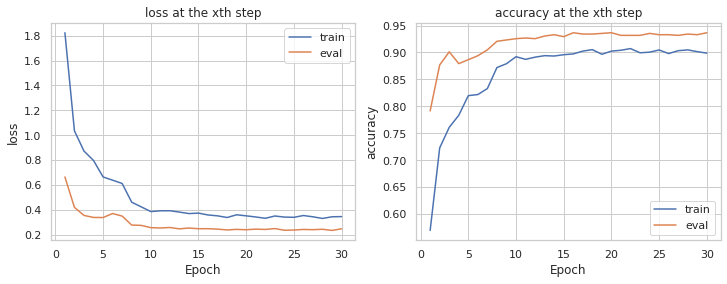

In [11]:
def visualize_accuracy(num_epochs, statistics):
    sns.set(style="whitegrid")
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
    for phase,(loss,acc) in statistics.items():
        loss_hist = [float(h) for h in loss]
        acc_hist = [float(h) for h in acc]
        ax1.plot(range(1,len(loss_hist)+1), loss_hist, label = phase)
        ax1.set(xlabel = 'Epoch', ylabel='loss',title='loss at the xth step');
        ax1.legend();
        ax2.plot(range(1,len(loss_hist)+1), acc_hist, label = phase)
        ax2.set(xlabel = 'Epoch', ylabel='accuracy',title='accuracy at the xth step');
        ax2.legend();
visualize_accuracy(num_epochs, statistics)

In [12]:
PATH = '/kaggle/working/'+ model_name + '_model_ft.pth'
torch.save(model_ft.state_dict(), PATH)

## test using model_ft

In [13]:
correct = 0
total = 0
class_correct = list(0. for i in range(num_classes))
class_total = list(0. for i in range(num_classes))

with torch.no_grad():
    for count,data in enumerate(dataloaders['test']):
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = model_ft(inputs)
        _, predicted = torch.max(outputs.data, 1)
        c = (predicted == labels).squeeze() # 去除size为1的维度
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        if count % 99 == 1:
            print('still testing...')

print('Accuracy of the model on test images: %d %%' % (100 * correct / total))
acc_dic = {}
for i in range(num_classes):
    acc = 100 * class_correct[i] / class_total[i]
    acc_dic[class_names[i]] = acc
    print('Accuracy of %5s : %2d %%' % (class_names[i], 100 * class_correct[i] / class_total[i]))

still testing...
still testing...
still testing...
Accuracy of the model on test images: 92 %
Accuracy of Faces : 79 %
Accuracy of Faces_easy : 98 %
Accuracy of Leopards : 100 %
Accuracy of Motorbikes : 100 %
Accuracy of accordion : 100 %
Accuracy of airplanes : 98 %
Accuracy of anchor : 62 %
Accuracy of   ant : 75 %
Accuracy of barrel : 88 %
Accuracy of  bass : 70 %
Accuracy of beaver : 55 %
Accuracy of binocular : 100 %
Accuracy of bonsai : 100 %
Accuracy of brain : 100 %
Accuracy of brontosaurus : 75 %
Accuracy of buddha : 94 %
Accuracy of butterfly : 77 %
Accuracy of camera : 90 %
Accuracy of cannon : 75 %
Accuracy of car_side : 100 %
Accuracy of ceiling_fan : 100 %
Accuracy of cellphone : 81 %
Accuracy of chair : 75 %
Accuracy of chandelier : 100 %
Accuracy of cougar_body : 77 %
Accuracy of cougar_face : 92 %
Accuracy of  crab : 71 %
Accuracy of crayfish : 57 %
Accuracy of crocodile : 60 %
Accuracy of crocodile_head : 60 %
Accuracy of   cup : 100 %
Accuracy of dalmatian : 100 %
Ac